통계분석실습 3차 과제 3번.

참고 사이트
https://www.kaggle.com/code/andreiguliaev/stroke-prediction-with-r-and-tidymodels

In [1]:
import pandas as pd
import numpy as np
from sklearn import *
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

import keras
from keras.models import Sequential
from keras.layers import Dense

In [2]:
stroke = pd.read_csv("C:/DataAnalysis/archive_SAP_report/healthcare-dataset-stroke-data.csv",
                     index_col = False, na_values = ["NaN"])

In [3]:
stroke = stroke.astype({
    "gender":"category",
    "ever_married":"category",
    "work_type":"category",
    "Residence_type":"category",
    "smoking_status":"category"
})
    # stroke의 문자형 변수를 범주형으로 변환
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5110 non-null   int64   
 1   gender             5110 non-null   category
 2   age                5110 non-null   float64 
 3   hypertension       5110 non-null   int64   
 4   heart_disease      5110 non-null   int64   
 5   ever_married       5110 non-null   category
 6   work_type          5110 non-null   category
 7   Residence_type     5110 non-null   category
 8   avg_glucose_level  5110 non-null   float64 
 9   bmi                4909 non-null   float64 
 10  smoking_status     5110 non-null   category
 11  stroke             5110 non-null   int64   
dtypes: category(5), float64(3), int64(4)
memory usage: 305.3 KB


데이터 전처리

    0. 자료형 변환
    
    1. 결측값 대체

<AxesSubplot:>

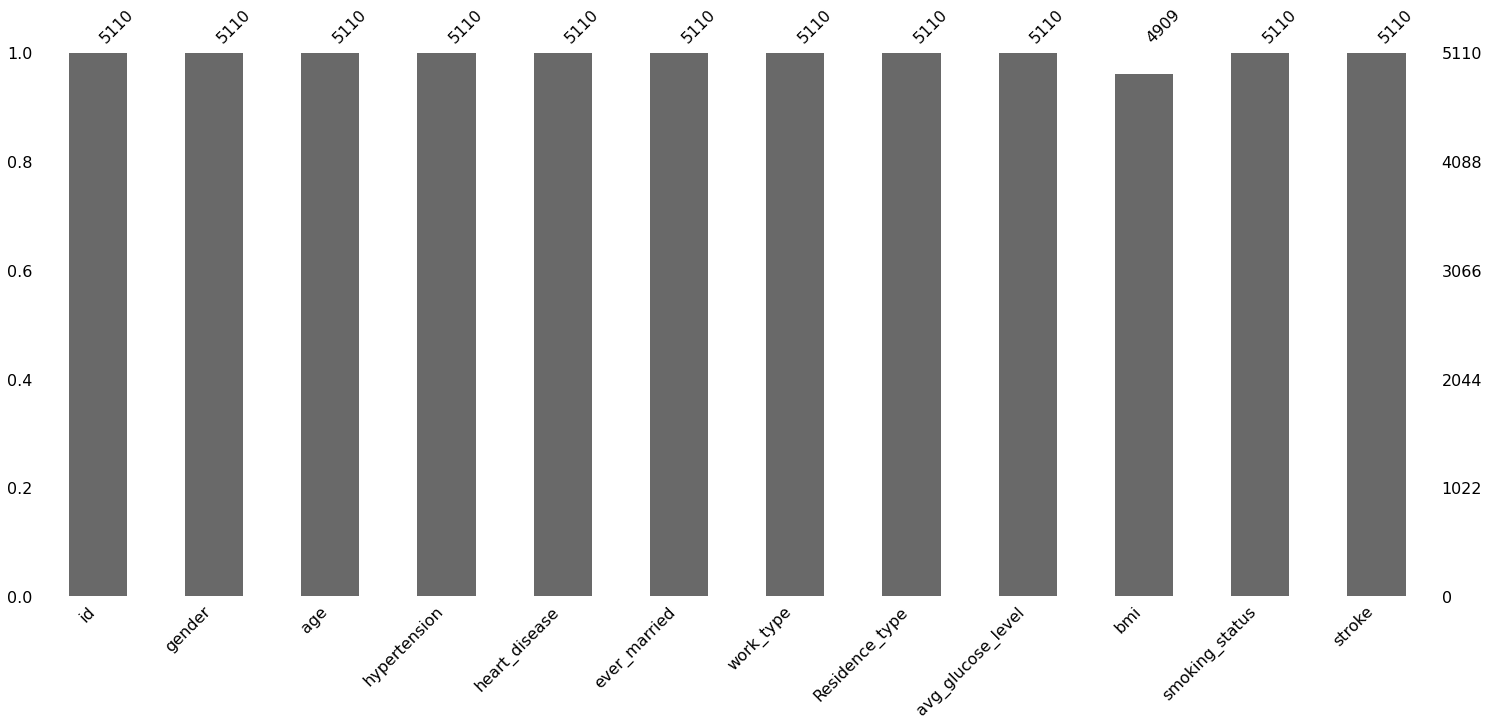

In [4]:
msno.bar(stroke)
    # 결측값 있는 smoking_status 변수

C:\Users\SOOYEO~1\AppData\Local\Temp/ipykernel_8228/406453965.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(stroke.corr(), dtype = np.bool)


<AxesSubplot:>

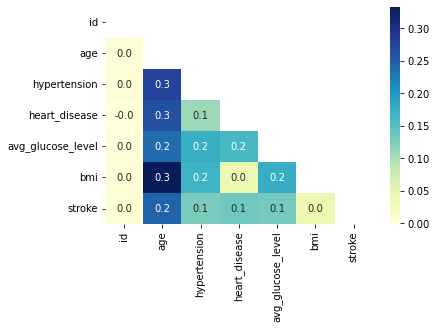

In [5]:
corr = stroke.corr()
mask = np.zeros_like(stroke.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
    # 상관분석 히트맵 삼각형 마스크(위 쪽 삼각형에 True, 아래 삼각형에 False)
sns.heatmap(data = corr, annot = True, fmt = ".1f", cmap = "YlGnBu", mask = mask)
    # 상관분석 결과 bmi와의 상관계수가 0.2 ~ 0.3인 hypertension, heart_disease, avg_glucose_level을 이용하여 결측값 대체 

In [6]:
NA_impute = KNNImputer()
    # NA값의 최근접 k개의 평균으로 결측값을 대체하는 k-nearest neighbor 보간법
NA_impute.fit(stroke.loc[:, ["bmi", "hypertension", "heart_disease", "avg_glucose_level"]])
stroke["bmi"] = NA_impute.transform(stroke.loc[:, ["bmi", "hypertension", "heart_disease", "avg_glucose_level"]])
stroke["bmi"].isnull().sum()

0

In [7]:
stroke["stroke"].unique()

array([1, 0], dtype=int64)

In [8]:
stroke["stroke"] = stroke["stroke"].astype("category")

데이터 전처리
    
    2. 이상치 탐지 및 처리
        
        - 3Q + 1.5*IQR 이상
        
        - μ + 3σ 이상
        
        - local outlier factor(Lof)
            local, neighbors 데이터의 상대적인 밀도를 비교하여 이상치 탐지하는 알고리즘
            시도하였으나 철회한 이유는 연속형 변수가 5차원으로 
            lof를 구현하기 위해서는 차원축소가 필요하기 때문
        
        - Isolation forest
            데이터 세트를 의사결정 나무로 표현하여 이상치를 의사결정 나무 
            상단 노드에서 분리하는 밀도 기반의 이상치 탐지하는 알고리즘

<AxesSubplot:>

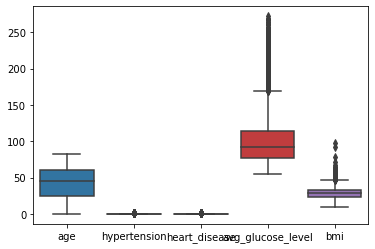

In [9]:
sns.boxplot(data = stroke.iloc[:, 1:11].select_dtypes(include = ["int64", "float64"]))
    # 3Q + 1.5*IQR 이상인 관측값이 존재하는 glucose_level, bmi 등

In [10]:
def outlier(data):
    IQR = data.quantile(0.75) - data.quantile(0.25)
    return pd.DataFrame(
        [[data.quantile(0.25)-(1.5 * IQR), data.quantile(0.75)+(1.5 * IQR)]] * data.shape[0],
        columns = ["lower", "upper"], 
        index = data.index)

In [11]:
outlier(stroke.iloc[:, 8]).iloc[0,:]
    # [glucose_level] 총 지출액의 이상치 판정기준 [21.9775, 169.3575]

lower     21.9775
upper    169.3575
Name: 0, dtype: float64

In [12]:
outlier(stroke.iloc[:, 9]).iloc[0,:]
    # [bmi] 총 지출액의 이상치 판정기준 [9.6, 47.2]

lower     9.6
upper    47.2
Name: 0, dtype: float64

In [13]:
stroke[stroke["avg_glucose_level"] >= 169.3575].count()
    # 627개 행

id                   627
gender               627
age                  627
hypertension         627
heart_disease        627
ever_married         627
work_type            627
Residence_type       627
avg_glucose_level    627
bmi                  627
smoking_status       627
stroke               627
dtype: int64

In [14]:
stroke[stroke["bmi"] >= 47.2].count()
    # 116개 행

id                   116
gender               116
age                  116
hypertension         116
heart_disease        116
ever_married         116
work_type            116
Residence_type       116
avg_glucose_level    116
bmi                  116
smoking_status       116
stroke               116
dtype: int64

In [15]:
describe = stroke.describe()
describe.drop("id", axis = 1, inplace = True)
    # 3σ로 이상치 탐지

In [16]:
describe.loc[9] = describe.loc["mean",:] + describe.loc["std",:]*3
describe.loc[10] = describe.loc["mean",:] - describe.loc["std",:]*3

In [17]:
describe.rename(index = {9:"UpperLimit", 10:"LowerLimit"})

age  hypertension  heart_disease  avg_glucose_level  \
count       5110.000000   5110.000000    5110.000000        5110.000000   
mean          43.226614      0.097456       0.054012         106.147677   
std           22.612647      0.296607       0.226063          45.283560   
min            0.080000      0.000000       0.000000          55.120000   
25%           25.000000      0.000000       0.000000          77.245000   
50%           45.000000      0.000000       0.000000          91.885000   
75%           61.000000      0.000000       0.000000         114.090000   
max           82.000000      1.000000       1.000000         271.740000   
UpperLimit   111.064555      0.987276       0.732201         241.998358   
LowerLimit   -24.611326     -0.792364      -0.624177         -29.703003   

                    bmi  
count       5110.000000  
mean          28.947221  
std            7.748575  
min           10.300000  
25%           23.700000  
50%           28.200000  
75%           33.100000  
max           97.600000  
UpperLimit    52.192947  
LowerLimit     5.701495

In [18]:
stroke[stroke["age"] >= 111.064555].count()
    # 0개 행

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [19]:
stroke[stroke["hypertension"] >= 0.987276].count()
    # 498개 행

id                   498
gender               498
age                  498
hypertension         498
heart_disease        498
ever_married         498
work_type            498
Residence_type       498
avg_glucose_level    498
bmi                  498
smoking_status       498
stroke               498
dtype: int64

In [20]:
stroke[stroke["heart_disease"] >= 0.732201].count()
    # 276개 행

id                   276
gender               276
age                  276
hypertension         276
heart_disease        276
ever_married         276
work_type            276
Residence_type       276
avg_glucose_level    276
bmi                  276
smoking_status       276
stroke               276
dtype: int64

In [21]:
stroke[stroke["avg_glucose_level"] >= 241.998358].count()
    # 49개 행

id                   49
gender               49
age                  49
hypertension         49
heart_disease        49
ever_married         49
work_type            49
Residence_type       49
avg_glucose_level    49
bmi                  49
smoking_status       49
stroke               49
dtype: int64

In [22]:
stroke[stroke["bmi"] >= 52.192947].count()
    # 59개 행

id                   59
gender               59
age                  59
hypertension         59
heart_disease        59
ever_married         59
work_type            59
Residence_type       59
avg_glucose_level    59
bmi                  59
smoking_status       59
stroke               59
dtype: int64

Isolation Forest Trial & Error 1

In [23]:
x = stroke.iloc[:, [2, 3, 4, 8, 9]]
y = stroke["stroke"]

In [24]:
x_train_outlier, x_test_outlier, y_train_outlier, y_test_outlier = train_test_split(x, y, test_size = 0.3, random_state = 2022) 

In [25]:
IsoFst = IsolationForest(random_state = 0)

In [26]:
IsoFst.fit(x_train_outlier)
y_pred_outlier = IsoFst.predict(x_test_outlier)

In [27]:
prediction = pd.DataFrame({"prediction" : y_pred_outlier})
    # 비지도학습 기반 이상치 탐지모델의 정밀도 평가
prediction["y_pred_outlier"] = np.where(prediction["prediction"] == -1, 1, 0)
y_pred_outlier = prediction["y_pred_outlier"]

In [28]:
print("Precision of Outlier Detection Model :", precision_score(y_test_outlier, y_pred_outlier))

Precision of Outlier Detection Model : 0.08757062146892655


In [29]:
print("Recall of Outlier Detection Model :", recall_score(y_test_outlier, y_pred_outlier))

Recall of Outlier Detection Model : 0.4696969696969697


In [30]:
stroke.groupby(["stroke"]).size()
    # 0 : 1 = 4861 : 249

stroke
0    4861
1     249
dtype: int64

In [31]:
print("F-1 score of Outlier Detection Model :", f1_score(y_test_outlier, y_pred_outlier))

F-1 score of Outlier Detection Model : 0.14761904761904762


Isolation Forest Trial & Error 2

In [32]:
model = IsolationForest(
    n_estimators = 100, max_samples = "auto", 
    n_jobs = -1, max_features = 2, contamination = 0.01)

In [33]:
model.fit(stroke.iloc[:, [2, 3, 4, 8, 9]].to_numpy())

IsolationForest(contamination=0.01, max_features=2, n_jobs=-1)

In [34]:
# 평가점수(score)와 이상치(anomaly) 판단 값 추가

df = pd.DataFrame()
score = model.decision_function(stroke.iloc[:, [2, 3, 4, 8, 9]].to_numpy())
outlier = model.predict(stroke.iloc[:, [2, 3, 4, 8, 9]].to_numpy())
df["score"] = score
df["outlier"] = outlier
anomaly_data = df.loc[df["outlier"] == -1]
len(anomaly_data)

52

In [35]:
anomaly_data

score  outlier
21   -0.008303       -1
33   -0.000048       -1
115  -0.002290       -1
171  -0.036634       -1
187  -0.026654       -1
193  -0.049163       -1
196  -0.028977       -1
201  -0.016877       -1
217  -0.018216       -1
218  -0.004550       -1
220  -0.054186       -1
243  -0.079907       -1
258  -0.014933       -1
382  -0.004622       -1
466  -0.028841       -1
785  -0.009785       -1
970  -0.002766       -1
1067 -0.038903       -1
1189 -0.043344       -1
1283 -0.056634       -1
1384 -0.033446       -1
1503 -0.027471       -1
1529 -0.022151       -1
1737 -0.055387       -1
1862 -0.017598       -1
2086 -0.003096       -1
2128 -0.022404       -1
2418 -0.004732       -1
2497 -0.001732       -1
2515 -0.005014       -1
2523 -0.006561       -1
2867 -0.037104       -1
3069 -0.000747       -1
3318 -0.010785       -1
3400 -0.001171       -1
3461 -0.014449       -1
3587 -0.004465       -1
3606 -0.033200       -1
3753 -0.028432       -1
3882 -0.034069       -1
3931 -0.020464       -1
3994 -0.006963       -1
4149 -0.029601       -1
4209 -0.021399       -1
4390 -0.016826       -1
4457 -0.021938       -1
4475 -0.011280       -1
4515 -0.004069       -1
4684 -0.000802       -1
4784 -0.004594       -1
4855 -0.068324       -1
4952 -0.009098       -1

In [36]:
anomaly_index = anomaly_data.index.values

In [37]:
print(*anomaly_index)
    # 이상치로 탐지된 행

21 33 115 171 187 193 196 201 217 218 220 243 258 382 466 785 970 1067 1189 1283 1384 1503 1529 1737 1862 2086 2128 2418 2497 2515 2523 2867 3069 3318 3400 3461 3587 3606 3753 3882 3931 3994 4149 4209 4390 4457 4475 4515 4684 4784 4855 4952


이상치 제거 후 표준화
    
    1. 이상치 데이터를 결측값으로 처리한 후 보간법으로 대체하는 방법
    2. 이상치로 탐지된 행 자체를 제거하는 방법 -> 선택

In [38]:
stroke.drop(anomaly_index, axis = 0, inplace = True)

In [39]:
stroke.shape
    # 5,110 -> 5,058

(5058, 12)

In [40]:
scaler = StandardScaler()

In [41]:
stroke.iloc[:, [2, 3, 4, 8, 9]] = scaler.fit_transform(stroke.iloc[:, [2, 3, 4, 8, 9]])

In [42]:
stroke

id  gender       age  hypertension  heart_disease ever_married  \
0      9046    Male  1.065432       -0.3125       4.510185          Yes   
1     51676  Female  0.799332       -0.3125      -0.221720          Yes   
2     31112    Male  1.641980       -0.3125       4.510185          Yes   
3     60182  Female  0.267134       -0.3125      -0.221720          Yes   
4      1665  Female  1.597630        3.2000      -0.221720          Yes   
...     ...     ...       ...           ...            ...          ...   
5105  18234  Female  1.641980        3.2000      -0.221720          Yes   
5106  44873  Female  1.686330       -0.3125      -0.221720          Yes   
5107  19723  Female -0.353764       -0.3125      -0.221720          Yes   
5108  37544    Male  0.355834       -0.3125      -0.221720          Yes   
5109  44679  Female  0.045385       -0.3125      -0.221720          Yes   

          work_type Residence_type  avg_glucose_level       bmi  \
0           Private          Urban           2.794572  1.023372   
1     Self-employed          Rural           2.195188  0.088411   
2           Private          Rural           0.015627  0.481939   
3           Private          Urban           1.493944  0.732847   
4     Self-employed          Rural           1.559360 -0.640542   
...             ...            ...                ...       ...   
5105        Private          Urban          -0.486199  0.648331   
5106  Self-employed          Urban           0.452037  1.472364   
5107  Self-employed          Rural          -0.503402  0.231032   
5108        Private          Rural           1.382125 -0.429251   
5109       Govt_job          Urban          -0.451567 -0.350017   

       smoking_status stroke  
0     formerly smoked      1  
1        never smoked      1  
2        never smoked      1  
3              smokes      1  
4        never smoked      1  
...               ...    ...  
5105     never smoked      0  
5106     never smoked      0  
5107     never smoked      0  
5108  formerly smoked      0  
5109          Unknown      0  

[5058 rows x 12 columns]

뉴럴 네트워크 모델 구축

In [43]:
# 원핫 인코딩

# encoder = LabelEncoder()
'''
def get_dummies(data, dummy_list):
    if not dummy_list:
        return data
    else: 
        df_ = pd.get_dummies(data = data, columns = dummy_list)
        return df_
'''

'\ndef get_dummies(data, dummy_list):\n    if not dummy_list:\n        return data\n    else: \n        df_ = pd.get_dummies(data = data, columns = dummy_list)\n        return df_\n'

In [76]:
# x = stroke.iloc[:, 0:10].values
# y = stroke["stroke"]

x0 = stroke.drop("stroke", axis = 1)
y = stroke["stroke"]
y = y.astype("int64")

In [77]:
x = pd.get_dummies(x0)
print(list(x.columns), x.shape)
print(list(x.columns), x.shape)

['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Female', 'gender_Male', 'gender_Other', 'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural', 'Residence_type_Urban', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes'] (5058, 22)
['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Female', 'gender_Male', 'gender_Other', 'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural', 'Residence_type_Urban', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes'] (5058, 22)


In [78]:
type(x)

pandas.core.frame.DataFrame

In [79]:
x

id       age  hypertension  heart_disease  avg_glucose_level  \
0      9046  1.065432       -0.3125       4.510185           2.794572   
1     51676  0.799332       -0.3125      -0.221720           2.195188   
2     31112  1.641980       -0.3125       4.510185           0.015627   
3     60182  0.267134       -0.3125      -0.221720           1.493944   
4      1665  1.597630        3.2000      -0.221720           1.559360   
...     ...       ...           ...            ...                ...   
5105  18234  1.641980        3.2000      -0.221720          -0.486199   
5106  44873  1.686330       -0.3125      -0.221720           0.452037   
5107  19723 -0.353764       -0.3125      -0.221720          -0.503402   
5108  37544  0.355834       -0.3125      -0.221720           1.382125   
5109  44679  0.045385       -0.3125      -0.221720          -0.451567   

           bmi  gender_Female  gender_Male  gender_Other  ever_married_No  \
0     1.023372              0            1             0                0   
1     0.088411              1            0             0                0   
2     0.481939              0            1             0                0   
3     0.732847              1            0             0                0   
4    -0.640542              1            0             0                0   
...        ...            ...          ...           ...              ...   
5105  0.648331              1            0             0                0   
5106  1.472364              1            0             0                0   
5107  0.231032              1            0             0                0   
5108 -0.429251              0            1             0                0   
5109 -0.350017              1            0             0                0   

      ...  work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0     ...                       0                  1                        0   
1     ...                       0                  0                        1   
2     ...                       0                  1                        0   
3     ...                       0                  1                        0   
4     ...                       0                  0                        1   
...   ...                     ...                ...                      ...   
5105  ...                       0                  1                        0   
5106  ...                       0                  0                        1   
5107  ...                       0                  0                        1   
5108  ...                       0                  1                        0   
5109  ...                       0                  0                        0   

      work_type_children  Residence_type_Rural  Residence_type_Urban  \
0                      0                     0                     1   
1                      0                     1                     0   
2                      0                     1                     0   
3                      0                     0                     1   
4                      0                     1                     0   
...                  ...                   ...                   ...   
5105                   0                     0                     1   
5106                   0                     0                     1   
5107                   0                     1                     0   
5108                   0                     1                     0   
5109                   0                     0                     1   

      smoking_status_Unknown  smoking_status_formerly smoked  \
0                          0                               1   
1                          0                               0   
2                          0                               0   
3                          0                               0   
4                          0                     

In [80]:
x = np.array(x)
y = np.array(y)

In [81]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 2023)

In [82]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4046, 22), (1012, 22), (4046,), (1012,))

In [98]:
ANN = Sequential()
    # 인공신경망 ANN 분류기

In [108]:
# 입력층 및 은닉층에 적용되는 활성화 함수(input layers and activation function)
# 첫번째 은닉층(hidden layers)
ANN.add(Dense(22, activation = "relu"))
    # 입력 노드(특성) 22개, 첫번째 은닉 계층 12개
    # 활성화 함수 : ReLu(정류 선형 규칙의 비선형 변환함수)

# 두번째 은닉층
ANN.add(Dense(12, activation = "relu"))

# 출력층(output layers)
ANN.add(Dense(1, activation = "sigmoid"))
    # 이진 분류 목적 츨력계층의 활성화 함수 : sigmoid, softmax

In [109]:
ANN.compile(
    optimizer = "adam", 
    loss = "binary_crossentropy", 
    metrics = ["accuracy"]
)
    # 최적화를 위해 가중치 변경하는 함수 Optimizer은 learning rate 즉, 스텝 방향과 스텝 사이즈 고려한 Adam(Adaptive Moment Estimation) 
    # 비용(손실)함수는 log loss(음의 로그 확률의 합)
    # FN(거짓음성)에 대한 성능 지표 재현률, stroke(뇌졸중) 발병하였는데 이상이 없다고 오진(오분류)

In [116]:
ANN.fit(np.array(x_train),np.array(y_train), batch_size = 30, epochs = 200)

Epoch 1/200
135/135 [==============================] - 0s 2ms/step - loss: 0.1896 - accuracy: 0.9530
Epoch 2/200
135/135 [==============================] - 0s 2ms/step - loss: 0.1897 - accuracy: 0.9530
Epoch 3/200
135/135 [==============================] - 0s 2ms/step - loss: 0.1897 - accuracy: 0.9530
Epoch 4/200
135/135 [==============================] - 0s 2ms/step - loss: 0.1898 - accuracy: 0.9530
Epoch 5/200
135/135 [==============================] - 0s 2ms/step - loss: 0.1895 - accuracy: 0.9530
Epoch 6/200
135/135 [==============================] - 0s 2ms/step - loss: 0.1897 - accuracy: 0.9530
Epoch 7/200
135/135 [==============================] - 0s 2ms/step - loss: 0.1897 - accuracy: 0.9530
Epoch 8/200
135/135 [==============================] - 0s 2ms/step - loss: 0.1897 - accuracy: 0.9530
Epoch 9/200
135/135 [==============================] - 0s 2ms/step - loss: 0.1897 - accuracy: 0.9530
Epoch 10/200
135/135 [==============================] - 0s 2ms/step - loss: 0.1896 - accura

In [151]:
y_pred = ANN.predict(x_test)

32/32 [==============================] - 0s 1ms/step


<AxesSubplot:>

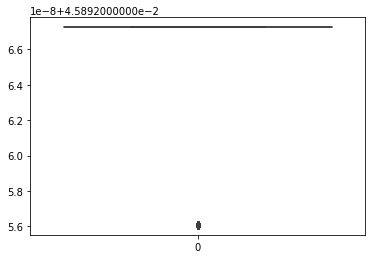

In [152]:
sns.boxplot(data = y_pred)

In [153]:
y_pred = pd.DataFrame(y_pred)

In [154]:
y_pred.describe()

0
count  1.012000e+03
mean   4.589186e-02
std    2.080301e-07
min    4.589206e-02
25%    4.589207e-02
50%    4.589207e-02
75%    4.589207e-02
max    4.589207e-02

In [155]:
4.589186e-02

0.04589186

In [156]:
y_pred = (y_pred > 0.0458)
    # 임계값

In [157]:
# optimizer = adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [158]:
metrics = confusion_matrix(y_test, y_pred)
loss, accuracy = ANN.evaluate(x_test, y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.1879 - accuracy: 0.9536


In [159]:
print("log loss :", loss)
print("accuracy :", accuracy)
print("Confusion Matrix : \n", metrics)
    # 극단적인 모델

log loss : 0.1879081130027771
accuracy : 0.9535573124885559
Confusion Matrix : 
 [[  0 965]
 [  0  47]]


In [160]:
ANN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 22)                506       
                                                                 
 dense_28 (Dense)            (None, 12)                276       
                                                                 
 dense_29 (Dense)            (None, 1)                 13        
                                                                 
 dense_30 (Dense)            (None, 22)                44        
                                                                 
 dense_31 (Dense)            (None, 12)                276       
                                                                 
 dense_32 (Dense)            (None, 1)                 13        
                                                                 
 dense_33 (Dense)            (None, 22)               

In [161]:
y_pred.groupby(0).size()

0
True    1012
dtype: int64